In [1]:
# Overleaf
# https://www.overleaf.com/9836375457csrqydskhcmj

# Init

In [2]:
# Libraries
import numpy as np
from math import *
from scipy.stats import norm
import matplotlib.pyplot as plt

In [3]:
# Option Characteristics
S0 = 100
K = 99
r = 0.06
sigma = 0.2
T = 1.0
M = 100_000

# Monte Carlo

In [13]:
# Finds value of an underlying at strike
def mc_value(S0, r, sigma, T, M, Z=[]):
    #dt = T/1    # N=1 Because of Geometric Brownian-Motion we can just simulate the variables at the final Time Step as Brownian Motion scales with time and independent increments.
    results = np.zeros(M)
    # Monte-Carlo Runs
    for i in range(M):
        S = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * np.random.normal())
        results[i] = S
    return results

# Finds value of option at strike
def mc_payoff(K, results, call, payoff_type):
    # Find option payoffs
    if payoff_type == "vanilla":
        if call:
            V = np.maximum(results - K, 0)
        else:
            V = np.maximum(K - results, 0)
    if payoff_type == "digital":
        if call:
            V = np.maximum(results - K, 0)
            V[V != 0] = 1
        else:
            V = np.maximum(K - results, 0)
            V[V != 0] = 1
    return V

# Finding Fair Value from Monte Carlo Simulation
mc_values = mc_value(S0, r, sigma, T, M)
mc_payoffs = mc_payoff(K, mc_values, call = True, payoff_type = "vanilla")
option_price = np.exp(-r * T) * np.mean(mc_payoffs)     # We have to discount the payoffs to calculate fair option's price
print(f"Option price: {option_price:.4f}")

# Finding Confidence Interval
standard_error = np.std(mc_payoffs, ddof=1) / np.sqrt(len(mc_payoffs))
t_stat = np.abs(norm.ppf(0.025))
margin_of_error = t_stat * standard_error
lower_bound = option_price - margin_of_error
upper_bound = option_price + margin_of_error
print(f"Standard error: {standard_error:.4f}")
print(f"95% Confidence interval: ({lower_bound:.4f}, {upper_bound:.4f})")

Option price: 11.5097
Standard error: 0.0512
95% Confidence interval: (11.4094, 11.6101)


# Approximating Delta

Should run each test for multiple times and show the confidence interval of deviation. With seed is much more stable

In [5]:
# Modified MC to support given random Z distribution values

def mc_value_seed(S0, r, sigma, T, M, Z):
    #dt = T/1    # N=1 Because of Geometric Brownian-Motion we can just simulate the variables at the final Time Step as Brownian Motion scales with time and independent increments.
    results = np.zeros(M)
    # Monte-Carlo Runs
    for i in range(M):
        S = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z[i])
        results[i] = S
    return results

In [35]:
# Finite Difference Method (with one side difference)

# Finding New Prices
finite_difference_step = 10.0            # Is not stable with lower values
S_delta = S0 + finite_difference_step

# Finding Approxiamation for Higher Price
mc_values = mc_value(S0, r, sigma, T, M)
mc_results = mc_payoff(K, mc_values, call = True, payoff_type = "vanilla")
option_price = np.exp(-r * T) * np.mean(mc_results)
# Finding Approxiamation for Lower Price
mc_values = mc_value(S_delta, r, sigma, T, M)
mc_results_diff = mc_payoff(K, mc_values, call = True, payoff_type = "vanilla")
option_price_diff = np.exp(-r * T) * np.mean(mc_results_diff)
# Approximation of Delta with Finite Differences
delta_approx = (option_price_diff - option_price) / finite_difference_step

# Print the results
print(f"Delta approximation: {delta_approx:.4f}")

Delta approximation: -0.2537


In [33]:
# Finite Difference Method (with one side difference and fixed seed)

# Setting seed and generating values
np.random.seed(np.random.randint(1000))
Z = np.random.normal(0, 1, M)

# Finding New Prices
finite_difference_step = 0.001            # Is much more stable with lower values
S_delta = S0 + finite_difference_step

# Finding Approxiamation for Higher Price
mc_values = mc_value_seed(S0, r, sigma, T, M, Z)
mc_results = mc_payoff(K, mc_values, call = True, payoff_type = "vanilla")
option_price = np.exp(-r * T) * np.mean(mc_results)
# Finding Approxiamation for Lower Price
mc_values = mc_value_seed(S_delta, r, sigma, T, M, Z)
mc_results_diff = mc_payoff(K, mc_values, call = True, payoff_type = "vanilla")
option_price_diff = np.exp(-r * T) * np.mean(mc_results_diff)
# Approximation of Delta with Finite Differences
delta_approx = (option_price_diff - option_price) / finite_difference_step

# Print the results
print(f"Delta approximation: {delta_approx:.4f}")

Delta approximation: -0.3255


In [31]:
# Finite Difference Method (With Lower and Higher)
# Should find paper from which I took it, as it is much better
# Or can just not include it

# Finding New Prices
finite_difference_step = 0.1
S_delta = S0 * finite_difference_step
S_up = S0 + S_delta
S_down = S0 - S_delta

# Finding Approxiamation for Higher Price
mc_values = mc_value(S_up, r, sigma, T, M)
mc_results_up = mc_payoff(K, mc_values, call = True, payoff_type = "vanilla")
option_price_up = np.exp(-r * T) * np.mean(mc_results_up)
# Finding Approxiamation for Lower Price
mc_values = mc_value(S_down, r, sigma, T, M)
mc_results_down = mc_payoff(K, mc_values, call = True, payoff_type = "vanilla")
option_price_down = np.exp(-r * T) * np.mean(mc_results_down)
# Approximation of Delta with Finite Differences
delta_approx = (option_price_up - option_price_down) / (2 * S_delta)

# Print the results
print(f"Delta approximation: {delta_approx:.4f}")

Delta approximation: -0.3335


In [9]:
# http://www.columbia.edu/~mh2078/MonteCarlo/MCS_Greeks.pdf
# https://people.maths.ox.ac.uk/gilesm/mc/module_6/adjoints/adjoints.pdf
# https://github.com/Redmek/Pricing-and-Hedging-of-Exotic-Options-Under-Black-Scholes-and-Heston-Models/blob/main/Pricing_exotic_options.ipynb

# # Pathwise
# # To work with digital option needs smoothing, as payoff is not continious
# delta_pathwise = 
# print(f"Delta approximation pathwise: {delta_pathwise:.4f}")

# # Likelihood
# delta_likelihood_ratio =
# print(f"Delta approximation likelihood: {delta_likelihood_ratio:.4f}")


# Asian Option

In [10]:
def d1_d2(S0, K, r, sigma, T):
    d1 = (log(S0/K) + (r+sigma**2/2)*T)/(sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    return d1,d2
def european_call_option_price(S0, K, r, T, d1, d2):
    return S0*norm.cdf(d1) - K*exp(-r*T)*norm.cdf(d2)


def asian_call_option_price(S0, N,sigma,K,r, T):
    '''
    :param S0: initial stock price
    :param N: Number of observations
    :param sigma: volatility
    :param K: strike price
    :param r: interest rate
    :param T: maturity time
    :return: asian option price
    '''
    asian_sigma = sigma*np.sqrt((2*N+1)/(6*(N+1)))
    asian_risk_free_interest = 0.5*((r-0.5*sigma**2) + asian_sigma**2)
    d1,d2=d1_d2(S0,K,asian_risk_free_interest, asian_sigma, T)
    A_N = european_call_option_price(S0, K,asian_risk_free_interest, T,d1, d2)
    return A_N

Asian Option price: 6.5496


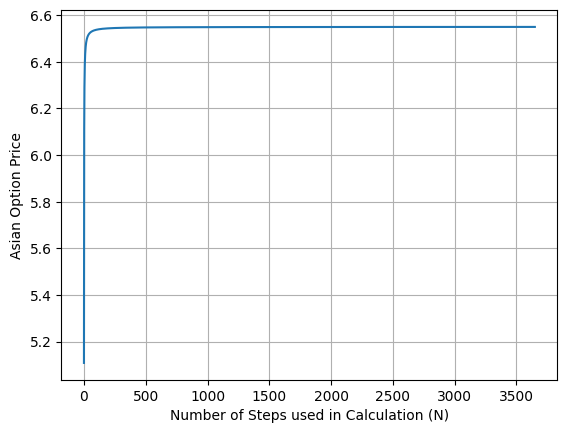

In [11]:
N = 3650
asian_option_price = asian_call_option_price(S0, N,sigma, K, r,T)
print(f"Asian Option price: {asian_option_price:.4f}")
all_n_vals = []
option_prices = []
for i in range(N):
    option_prices.append(asian_call_option_price(S0, i,sigma, K, r,T))
    all_n_vals.append(i)
    
plt.plot(all_n_vals,option_prices)
plt.grid()
plt.xlabel("Number of Steps used in Calculation (N)")
plt.ylabel("Asian Option Price")
plt.show()